In [1]:
import re
import pprint
import numpy as np
import sympy as sp
import openturns as ot
import matplotlib.pyplot as plt
import trimesh as tr

from math import pi
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display
from time import time
from sympy.printing import latex
from trimesh import viewer as trview

import iota

# **In this Notebook, we will reanalyze the simple hyperstatic system, previously in 2D in AnalyseDenavitModele2DTrousCarres, but this time in 3D. The method based on a matrix representation of the mechanism and the use of topological loops remains the same.**

### First, we need to define the various matrices of our 3D chain.
By leveraging the classes and methods available in our "trip_symbolic_tolerance_analysis" module, we can adapt the transformation matrices, defects, and clearances for a three-dimensional analysis.


#### **Definition of Nominal Component Values**


In [2]:
hM, hF = 10, 10.2  # Male / Female height
wM, wF = 10, 10.2  # Male / Female width
dM, dF = 10, 10.2  # Male / Female depth
L1 = L3 = 30  # Length 1
L2 = 70  # Length 2
PG = 30  # Global depth

#### **Definition of Global Frame R0 / Which Also Serves as a Local Frame for the Fixed Component.**


#### **Defining the Coordinates of Key Points on Each Surface of Each Component.**


In [3]:
ar = np.array

PointDict = {}
# Part 1 (male)
# Base Surface k
PointDict["P1K0"] = ar([0, 0, 0])  # Global-Midpoint

# Left Pin
# Surface a - Left Side
PointDict["P1A0"] = ar([-(L2 + wM) / 2, hM / 2, 0])  # Midpoint
# Surface b - Front
PointDict["P1B0"] = ar([-L2 / 2, hM / 2, dM / 2])  # Midpoint
# Surface c - Right Side
PointDict["P1C0"] = ar([-(L2 - wM) / 2, hM / 2, 0])  # Midpoint
# Surface d - Back
PointDict["P1D0"] = ar([-L2 / 2, hM / 2, -dM / 2])  # Midpoint
# Surface e - Top
PointDict["P1E0"] = ar([-L2 / 2, hM, 0])  # Midpoint

# Right Pin
# Surface f - Left Side
PointDict["P1F0"] = ar([(L2 - wM) / 2, hM / 2, 0])  # Midpoint
# Surface g - Front
PointDict["P1G0"] = ar([L2 / 2, hM / 2, dM / 2])  # Midpoint
# Surface h - Right Side
PointDict["P1H0"] = ar([(L2 + wM) / 2, hM / 2, 0])  # Midpoint
# Surface i - Back (with counter-clockwise winding when viewed from behind)
PointDict["P1I0"] = ar([L2 / 2, hM / 2, -dM / 2])  # Midpoint
# Surface j - Top
PointDict["P1J0"] = ar([L2 / 2, hM, 0])  # Midpoint

# Part 2 (female)
# Base Surface k
PointDict["P2K0"] = ar([0, 0, 0])  # Global-Midpoint

# Left Hole
# Surface a - Left Side
PointDict["P2A0"] = ar([-(L2 + wF) / 2, hF / 2, 0])  # Midpoint
# Surface b - Front
PointDict["P2B0"] = ar([-L2 / 2, hF / 2, dF / 2])  # Midpoint
# Surface c - Right Side
PointDict["P2C0"] = ar([-(L2 - wF) / 2, hF / 2, 0])  # Midpoint
# Surface d - Back
PointDict["P2D0"] = ar([-L2 / 2, hF / 2, -dF / 2])  # Midpoint
# Surface e - Top
PointDict["P2E0"] = ar([-L2 / 2, hF, 0])  # Midpoint

# Right Hole
# Surface f - Left Side
PointDict["P2F0"] = ar([(L2 - wF) / 2, hF / 2, 0])  # Midpoint
# Surface g - Front
PointDict["P2G0"] = ar([L2 / 2, hF / 2, dF / 2])  # Midpoint
# Surface h - Right Side
PointDict["P2H0"] = ar([(L2 + wF) / 2, hF / 2, 0])  # Midpoint
# Surface i - Back
PointDict["P2I0"] = ar([L2 / 2, hF / 2, -dF / 2])  # Midpoint
# Surface j - Top
PointDict["P2J0"] = ar([L2 / 2, hF, 0])  # Midpoint

In [4]:
# Base Surface k
PointDict["P1K1"] = ar((-L2 / 2 - L1, 0, PG / 2))  # Left-Bottom-Front
PointDict["P1K2"] = ar((L2 / 2 + L1, 0, PG / 2))  # Right-Bottom-Front
PointDict["P1K3"] = ar((L2 / 2 + L1, 0, -PG / 2))  # Right-Bottom-Back
PointDict["P1K4"] = ar((-L2 / 2 - L1, 0, -PG / 2))  # Left-Bottom-Back
# Surface a - Left Side
PointDict["P1A1"] = ar((-(L2 + wM) / 2, 0, dM / 2))  # Left-Bottom-Front
PointDict["P1A2"] = ar((-(L2 + wM) / 2, hM, dM / 2))  # Left-Top-Front
PointDict["P1A3"] = ar((-(L2 + wM) / 2, hM, -dM / 2))  # Left-Top-Back
PointDict["P1A4"] = ar((-(L2 + wM) / 2, 0, -dM / 2))  # Left-Bottom-Back
# Surface b - Front
PointDict["P1B1"] = ar((-(L2 + wM) / 2, 0, dM / 2))  # Left-Bottom-Front
PointDict["P1B2"] = ar((-(L2 - wM) / 2, 0, dM / 2))  # Right-Bottom-Front
PointDict["P1B3"] = ar((-(L2 - wM) / 2, hM, dM / 2))  # Right-Top-Front
PointDict["P1B4"] = ar((-(L2 + wM) / 2, hM, dM / 2))  # Left-Top-Front
# Surface c - Right Side
PointDict["P1C1"] = ar((-(L2 - wM) / 2, 0, dM / 2))  # Right-Bottom-Front
PointDict["P1C2"] = ar((-(L2 - wM) / 2, hM, dM / 2))  # Right-Top-Front
PointDict["P1C3"] = ar((-(L2 - wM) / 2, hM, -dM / 2))  # Right-Top-Back
PointDict["P1C4"] = ar((-(L2 - wM) / 2, 0, -dM / 2))  # Right-Bottom-Back
# Surface d - Back
PointDict["P1D1"] = ar((-(L2 - wM) / 2, 0, -dM / 2))  # Right-Bottom-Back
PointDict["P1D2"] = ar((-(L2 + wM) / 2, 0, -dM / 2))  # Left-Bottom-Back
PointDict["P1D3"] = ar((-(L2 + wM) / 2, hM, -dM / 2))  # Left-Top-Back
PointDict["P1D4"] = ar((-(L2 - wM) / 2, hM, -dM / 2))  # Right-Top-Back
# Surface e - Top
PointDict["P1E1"] = ar((-(L2 + wM) / 2, hM, dM / 2))  # Left-Front-Top
PointDict["P1E2"] = ar((-(L2 - wM) / 2, hM, dM / 2))  # Right-Front-Top
PointDict["P1E3"] = ar((-(L2 - wM) / 2, hM, -dM / 2))  # Right-Back-Top
PointDict["P1E4"] = ar((-(L2 + wM) / 2, hM, -dM / 2))  # Left-Back-Top
# Right Pin
# Surface f - Left Side
PointDict["P1F1"] = ar(((L2 - wM) / 2, 0, dM / 2))  # Left-Bottom-Front
PointDict["P1F2"] = ar(((L2 - wM) / 2, hM, dM / 2))  # Left-Top-Front
PointDict["P1F3"] = ar(((L2 - wM) / 2, hM, -dM / 2))  # Left-Top-Back
PointDict["P1F4"] = ar(((L2 - wM) / 2, 0, -dM / 2))  # Left-Bottom-Back
# Surface g - Front
PointDict["P1G1"] = ar(((L2 - wM) / 2, 0, dM / 2))  # Left-Bottom-Front
PointDict["P1G2"] = ar(((L2 + wM) / 2, 0, dM / 2))  # Right-Bottom-Front
PointDict["P1G3"] = ar(((L2 + wM) / 2, hM, dM / 2))  # Right-Top-Front
PointDict["P1G4"] = ar(((L2 - wM) / 2, hM, dM / 2))  # Left-Top-Front
# Surface h - Right Side
PointDict["P1H1"] = ar(((L2 + wM) / 2, 0, dM / 2))  # Right-Bottom-Front
PointDict["P1H2"] = ar(((L2 + wM) / 2, hM, dM / 2))  # Right-Top-Front
PointDict["P1H3"] = ar(((L2 + wM) / 2, hM, -dM / 2))  # Right-Top-Back
PointDict["P1H4"] = ar(((L2 + wM) / 2, 0, -dM / 2))  # Right-Bottom-Back
# Surface i - Back (with counter-clockwise winding when viewed from behind)
PointDict["P1I1"] = ar(((L2 + wM) / 2, 0, -dM / 2))  # Right-Bottom-Back
PointDict["P1I2"] = ar(((L2 - wM) / 2, 0, -dM / 2))  # Left-Bottom-Back
PointDict["P1I3"] = ar(((L2 - wM) / 2, hM, -dM / 2))  # Left-Top-Back
PointDict["P1I4"] = ar(((L2 + wM) / 2, hM, -dM / 2))  # Right-Top-Back
# Surface j - Top
PointDict["P1J1"] = ar(((L2 - wM) / 2, hM, dM / 2))  # Left-Front-Top
PointDict["P1J2"] = ar(((L2 + wM) / 2, hM, dM / 2))  # Right-Front-Top
PointDict["P1J3"] = ar(((L2 + wM) / 2, hM, -dM / 2))  # Right-Back-Top
PointDict["P1J4"] = ar(((L2 - wM) / 2, hM, -dM / 2))  # Left-Back-Top

In [5]:
# Base Surface k
PointDict["P2K1"] = ar((-L2 / 2 - L1, 0, PG / 2))  # Left-Bottom-Front
PointDict["P2K2"] = ar((L2 / 2 + L1, 0, PG / 2))  # Right-Bottom-Front
PointDict["P2K3"] = ar((L2 / 2 + L1, 0, -PG / 2))  # Right-Bottom-Back
PointDict["P2K4"] = ar((-L2 / 2 - L1, 0, -PG / 2))  # Left-Bottom-Back
# Left Pin
# Surface a - Left Side
PointDict["P2A1"] = ar((-(L2 + wF) / 2, 0, dF / 2))  # Left-Bottom-Front
PointDict["P2A2"] = ar((-(L2 + wF) / 2, hF, dF / 2))  # Left-Top-Front
PointDict["P2A3"] = ar((-(L2 + wF) / 2, hF, -dF / 2))  # Left-Top-Back
PointDict["P2A4"] = ar((-(L2 + wF) / 2, 0, -dF / 2))  # Left-Bottom-Back
# Surface b - Front
PointDict["P2B1"] = ar((-(L2 + wF) / 2, 0, dF / 2))  # Left-Bottom-Front
PointDict["P2B2"] = ar((-(L2 - wF) / 2, 0, dF / 2))  # Right-Bottom-Front
PointDict["P2B3"] = ar((-(L2 - wF) / 2, hF, dF / 2))  # Right-Top-Front
PointDict["P2B4"] = ar((-(L2 + wF) / 2, hF, dF / 2))  # Left-Top-Front
# Surface c - Right Side
PointDict["P2C1"] = ar((-(L2 - wF) / 2, 0, dF / 2))  # Right-Bottom-Front
PointDict["P2C2"] = ar((-(L2 - wF) / 2, hF, dF / 2))  # Right-Top-Front
PointDict["P2C3"] = ar((-(L2 - wF) / 2, hF, -dF / 2))  # Right-Top-Back
PointDict["P2C4"] = ar((-(L2 - wF) / 2, 0, -dF / 2))  # Right-Bottom-Back
# Surface d - Back
PointDict["P2D1"] = ar((-(L2 - wF) / 2, 0, -dF / 2))  # Right-Bottom-Back
PointDict["P2D2"] = ar((-(L2 + wF) / 2, 0, -dF / 2))  # Left-Bottom-Back
PointDict["P2D3"] = ar((-(L2 + wF) / 2, hF, -dF / 2))  # Left-Top-Back
PointDict["P2D4"] = ar((-(L2 - wF) / 2, hF, -dF / 2))  # Right-Top-Back
# Surface e - Top
PointDict["P2E1"] = ar((-(L2 + wF) / 2, hF, dF / 2))  # Left-Front-Bottom
PointDict["P2E2"] = ar((-(L2 - wF) / 2, hF, dF / 2))  # Right-Front-Bottom
PointDict["P2E3"] = ar((-(L2 - wF) / 2, hF, -dF / 2))  # Right-Back-Bottom
PointDict["P2E4"] = ar((-(L2 + wF) / 2, hF, -dF / 2))  # Left-Back-Bottom
# Right Pin
# Surface f - Left Side
PointDict["P2F1"] = ar(((L2 - wF) / 2, 0, dF / 2))  # Left-Bottom-Front
PointDict["P2F2"] = ar(((L2 - wF) / 2, hF, dF / 2))  # Left-Top-Front
PointDict["P2F3"] = ar(((L2 - wF) / 2, hF, -dF / 2))  # Left-Top-Back
PointDict["P2F4"] = ar(((L2 - wF) / 2, 0, -dF / 2))  # Left-Bottom-Back
# Surface g - Front
PointDict["P2G1"] = ar(((L2 - wF) / 2, 0, dF / 2))  # Left-Bottom-Front
PointDict["P2G2"] = ar(((L2 + wF) / 2, 0, dF / 2))  # Right-Bottom-Front
PointDict["P2G3"] = ar(((L2 + wF) / 2, hF, dF / 2))  # Right-Top-Front
PointDict["P2G4"] = ar(((L2 - wF) / 2, hF, dF / 2))  # Left-Top-Front
# Surface h - Right Side
PointDict["P2H1"] = ar(((L2 + wF) / 2, 0, dF / 2))  # Right-Bottom-Front
PointDict["P2H2"] = ar(((L2 + wF) / 2, hF, dF / 2))  # Right-Top-Front
PointDict["P2H3"] = ar(((L2 + wF) / 2, hF, -dF / 2))  # Right-Top-Back
PointDict["P2H4"] = ar(((L2 + wF) / 2, 0, -dF / 2))  # Right-Bottom-Back
# Surface i - Back (with counter-clockwise winding when viewed from behind)
PointDict["P2I1"] = ar(((L2 + wF) / 2, 0, -dF / 2))  # Right-Bottom-Back
PointDict["P2I2"] = ar(((L2 - wF) / 2, 0, -dF / 2))  # Left-Bottom-Back
PointDict["P2I3"] = ar(((L2 - wF) / 2, hF, -dF / 2))  # Left-Top-Back
PointDict["P2I4"] = ar(((L2 + wF) / 2, hF, -dF / 2))  # Right-Top-Back
# Surface j - Top
PointDict["P2J1"] = ar(((L2 - wF) / 2, hF, dF / 2))  # Left-Front-Top
PointDict["P2J2"] = ar(((L2 + wF) / 2, hF, dF / 2))  # Right-Front-Top
PointDict["P2J3"] = ar(((L2 + wF) / 2, hF, -dF / 2))  # Right-Back-Top
PointDict["P2J4"] = ar(((L2 - wF) / 2, hF, -dF / 2))  # Left-Back-Top

In [6]:
k1, k2 = lambda x: x.startswith("P1"), lambda x: x.startswith("P2")
points_part1 = np.stack(list({k: v for k, v in PointDict.items() if k1(k)}.values()))
points_part2 = np.stack(list({k: v for k, v in PointDict.items() if k2(k)}.values()))
spheres1 = iota.spheres_from_point_cloud(
    points_part1,
    radius=0.3,
    color=[43, 107, 223, 1],
    global_translation=np.array([0, 0, 0]),
)
spheres2 = iota.spheres_from_point_cloud(
    points_part2,
    radius=0.3,
    color=[223, 43, 43, 1],
    global_translation=np.array([0, 0, 0]),
)

In [7]:
# trview.notebook.scene_to_notebook(tr.Scene([*spheres1, *spheres2]))

#### **Defining the Local Frames for Each Substituted Surface.**
For Part 1 (male):

In [8]:
R0 = ar([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

FrameDict = {}
# Base Surface k
FrameDict["RP1k"] = ar([y_, -x_, z_])

# Left Pin
# Surface a - Left Side
FrameDict["RP1a"] = ar([-x_, -y_, z_])
# Surface b - Front
FrameDict["RP1b"] = ar([z_, y_, -x_])
# Surface c - Right Side
FrameDict["RP1c"] = ar([x_, y_, z_])
# Surface d - Back
FrameDict["RP1d"] = ar([-z_, y_, x_])
# Surface e - Top
FrameDict["RP1e"] = ar([y_, -x_, z_])

# Right pin
# Surface f - Left Side
FrameDict["RP1f"] = ar([-x_, -y_, z_])
# Surface g - Front
FrameDict["RP1g"] = ar([z_, y_, -x_])
# Surface h - Right Side
FrameDict["RP1h"] = ar([x_, y_, z_])
# Surface i - Back
FrameDict["RP1i"] = ar([-z_, y_, x_])
# Surface j - Top
FrameDict["RP1j"] = ar([y_, -x_, z_])

For Part 2 (female):

In [9]:
# Base Surface k
FrameDict["RP2k"] = ar([-y_, x_, z_])

# Left Hole
# Surface a - Left Side
FrameDict["RP2a"] = ar([x_, y_, z_])
# Surface b - Front
FrameDict["RP2b"] = ar([-z_, y_, x_])
# Surface c - Right Side
FrameDict["RP2c"] = ar([-x_, y_, -z_])
# Surface d - Back
FrameDict["RP2d"] = ar([z_, y_, -x_])
# Surface e - Top
FrameDict["RP2e"] = ar([-y_, x_, z_])

# Right Hole
# Surface f - Left Side
FrameDict["RP2f"] = ar([x_, y_, z_])
# Surface g - Front
FrameDict["RP2g"] = ar([-z_, y_, x_])
# Surface h - Right Side
FrameDict["RP2h"] = ar([-x_, y_, -z_])
# Surface i - Back
FrameDict["RP2i"] = ar([z_, y_, -x_])
# Surface j - Top
FrameDict["RP2j"] = ar([-y_, x_, z_])

In [10]:
FrameDict = {frame: arr.T for frame, arr in FrameDict.items()}

In [11]:
system_data = {
    "PARTS": {
        "1": {
            "a": {
                "FRAME": FrameDict["RP1a"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1A")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2a"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "b": {
                "FRAME": FrameDict["RP1b"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1B")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2b"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "c": {
                "FRAME": FrameDict["RP1c"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1C")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2c"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "d": {
                "FRAME": FrameDict["RP1d"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1D")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2d"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "e": {
                "FRAME": FrameDict["RP1e"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1E")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2e"],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "f": {
                "FRAME": FrameDict["RP1f"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1F")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2f"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "g": {
                "FRAME": FrameDict["RP1g"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1G")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2g"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "h": {
                "FRAME": FrameDict["RP1h"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1H")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2h"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "i": {
                "FRAME": FrameDict["RP1i"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1I")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2i"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "j": {
                "FRAME": FrameDict["RP1j"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1J")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2j"],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "k": {
                "FRAME": FrameDict["RP1k"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P1K")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P2k"],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],
            },
        },
        "2": {
            "a": {
                "FRAME": FrameDict["RP2a"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2A")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1a"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "b": {
                "FRAME": FrameDict["RP2b"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2B")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1b"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "c": {
                "FRAME": FrameDict["RP2c"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2C")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1c"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "d": {
                "FRAME": FrameDict["RP2d"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2D")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1d"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "e": {
                "FRAME": FrameDict["RP2e"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2E")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1e"],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "f": {
                "FRAME": FrameDict["RP2f"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2F")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1f"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "g": {
                "FRAME": FrameDict["RP2g"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2G")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1g"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "h": {
                "FRAME": FrameDict["RP2h"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2H")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1h"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "i": {
                "FRAME": FrameDict["RP2i"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2I")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1i"],
                "CONSTRAINTS_D": ["NONE"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "j": {
                "FRAME": FrameDict["RP2j"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2J")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1j"],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "k": {
                "FRAME": FrameDict["RP2k"],
                "POINTS": {
                    k[2:]: v for k, v in PointDict.items() if k.startswith("P2K")
                },
                "TYPE": "plane",
                "INTERACTIONS": ["P1k"],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],
            },
        },
    },
    "LOOPS": {
        "COMPATIBILITY": {
            "L1": "P1kK0 -> P1aA0 -> P2aA0 -> P2kK0",
            "L2": "P1kK0 -> P1bB0 -> P2bB0 -> P2kK0",
            "L3": "P1kK0 -> P1cC0 -> P2cC0 -> P2kK0",
            "L4": "P1kK0 -> P1dD0 -> P2dD0 -> P2kK0",
            "L5": "P1kK0 -> P1eE0 -> P2eE0 -> P2kK0",
            "L6": "P1kK0 -> P1fF0 -> P2fF0 -> P2kK0",
            "L7": "P1kK0 -> P1gG0 -> P2gG0 -> P2kK0",
            "L8": "P1kK0 -> P1hH0 -> P2hH0 -> P2kK0",
            "L9": "P1kK0 -> P1iI0 -> P2iI0 -> P2kK0",
            "L10": "P1kK0 -> P1jJ0 -> P2jJ0 -> P2kK0",
        },
    },
    "GLOBAL_CONSTRAINTS": "3D",
}

In [12]:
SDA = iota.AssemblyDataProcessor(system_data)
SDA.generate_expanded_loops()

In [13]:
CLH = iota.CompatibilityLoopHandling(SDA)

In [14]:
ILH = iota.InterfaceLoopHandling(SDA, CLH)
#ILH.facing_point_dict

Processing part 1, surface a for plane-to-plane interactions.
usedGMatDat [['1', 'a', 'A0', '2', 'a', 'A0']]
Found 1 used gap matrices.
unusedGMatDat [['1', 'a', 'A4', '2', 'a', 'A4'], ['1', 'a', 'A1', '2', 'a', 'A1'], ['1', 'a', 'A3', '2', 'a', 'A3'], ['1', 'a', 'A2', '2', 'a', 'A2']]
Found 4 unused gap matrices.
Generated 4 interaction matrix loops for current matching.
Processing part 1, surface b for plane-to-plane interactions.
usedGMatDat [['1', 'b', 'B0', '2', 'b', 'B0']]
Found 1 used gap matrices.
unusedGMatDat [['1', 'b', 'B4', '2', 'b', 'B4'], ['1', 'b', 'B1', '2', 'b', 'B1'], ['1', 'b', 'B3', '2', 'b', 'B3'], ['1', 'b', 'B2', '2', 'b', 'B2']]
Found 4 unused gap matrices.
Generated 4 interaction matrix loops for current matching.
Processing part 1, surface c for plane-to-plane interactions.
usedGMatDat [['1', 'c', 'C0', '2', 'c', 'C0']]
Found 1 used gap matrices.
unusedGMatDat [['1', 'c', 'C3', '2', 'c', 'C3'], ['1', 'c', 'C4', '2', 'c', 'C4'], ['1', 'c', 'C1', '2', 'c', 'C1'

In [15]:
print("### Compatibility equations : ###")
for i in range(len(CLH.compatibility_expressions)):
    display(sp.simplify(CLH.compatibility_expressions[i]))

### Compatibility equations : ###


-gamma_d_0 + gamma_d_1 - gamma_g_0

alpha_g_0

alpha_g_1 + beta_d_0 + beta_d_1 + beta_g_0

401*gamma_d_0/10 - 401*gamma_d_1/10 + 401*gamma_g_0/10 - v_g_0

-5*gamma_d_0 + 51*gamma_d_1/10 - 5*gamma_g_0 + u_d_0 + u_d_1 + u_g_0 - v_g_1 - 1/10

5*alpha_g_0 + 401*beta_d_0/10 + 401*beta_d_1/10 + 401*beta_g_0/10 + w_g_0 + w_g_1

-alpha_g_2

gamma_d_4 + gamma_d_5 + gamma_g_2

alpha_g_1 - beta_d_4 + beta_d_5 - beta_g_2

35*alpha_g_2 - 51*gamma_d_4/10 - 51*gamma_d_5/10 - 51*gamma_g_2/10 + v_g_2

-5*alpha_g_2 + 51*beta_d_4/10 - 51*beta_d_5/10 + 51*beta_g_2/10 - v_g_1 + w_g_2

-35*beta_d_4 + 35*beta_d_5 - 35*beta_g_2 + 5*gamma_d_4 + 51*gamma_d_5/10 + 5*gamma_g_2 + u_d_4 + u_d_5 + u_g_2 + w_g_1 - 1/10

-gamma_d_6 - gamma_d_7 - gamma_g_3

-alpha_g_3

alpha_g_1 - beta_d_6 + beta_d_7 - beta_g_3

299*gamma_d_6/10 + 299*gamma_d_7/10 + 299*gamma_g_3/10 + v_g_3

-5*gamma_d_6 - 51*gamma_d_7/10 - 5*gamma_g_3 - u_d_6 - u_d_7 - u_g_3 - v_g_1 + 1/10

-5*alpha_g_3 - 299*beta_d_6/10 + 299*beta_d_7/10 - 299*beta_g_3/10 + w_g_1 + w_g_3

alpha_g_4

-gamma_d_8 - gamma_d_9 - gamma_g_4

alpha_g_1 - beta_d_8 + beta_d_9 - beta_g_4

-35*alpha_g_4 - 51*gamma_d_8/10 - 51*gamma_d_9/10 - 51*gamma_g_4/10 + v_g_4

5*alpha_g_4 - 51*beta_d_8/10 + 51*beta_d_9/10 - 51*beta_g_4/10 - v_g_1 - w_g_4

-35*beta_d_8 + 35*beta_d_9 - 35*beta_g_4 - 5*gamma_d_8 - 51*gamma_d_9/10 - 5*gamma_g_4 - u_d_8 - u_d_9 - u_g_4 + w_g_1 + 1/10

-gamma_g_5

beta_g_5

alpha_g_1 - alpha_g_5

35*gamma_g_5 + u_g_5 - 1/5

-51*gamma_g_5/5 - v_g_1 + v_g_5

-35*alpha_g_5 + 51*beta_g_5/5 + w_g_1 + w_g_5

-gamma_d_12 + gamma_d_13 - gamma_g_6

alpha_g_6

alpha_g_1 + beta_d_12 + beta_d_13 + beta_g_6

-299*gamma_d_12/10 + 299*gamma_d_13/10 - 299*gamma_g_6/10 - v_g_6

-5*gamma_d_12 + 51*gamma_d_13/10 - 5*gamma_g_6 + u_d_12 + u_d_13 + u_g_6 - v_g_1 - 1/10

5*alpha_g_6 - 299*beta_d_12/10 - 299*beta_d_13/10 - 299*beta_g_6/10 + w_g_1 + w_g_6

-alpha_g_7

gamma_d_14 + gamma_d_15 + gamma_g_7

alpha_g_1 - beta_d_14 + beta_d_15 - beta_g_7

-35*alpha_g_7 - 51*gamma_d_14/10 - 51*gamma_d_15/10 - 51*gamma_g_7/10 + v_g_7

-5*alpha_g_7 + 51*beta_d_14/10 - 51*beta_d_15/10 + 51*beta_g_7/10 - v_g_1 + w_g_7

35*beta_d_14 - 35*beta_d_15 + 35*beta_g_7 + 5*gamma_d_14 + 51*gamma_d_15/10 + 5*gamma_g_7 + u_d_14 + u_d_15 + u_g_7 + w_g_1 - 1/10

-gamma_d_16 - gamma_d_17 - gamma_g_8

-alpha_g_8

alpha_g_1 - beta_d_16 + beta_d_17 - beta_g_8

-401*gamma_d_16/10 - 401*gamma_d_17/10 - 401*gamma_g_8/10 + v_g_8

-5*gamma_d_16 - 51*gamma_d_17/10 - 5*gamma_g_8 - u_d_16 - u_d_17 - u_g_8 - v_g_1 + 1/10

-5*alpha_g_8 + 401*beta_d_16/10 - 401*beta_d_17/10 + 401*beta_g_8/10 + w_g_1 + w_g_8

alpha_g_9

-gamma_d_18 - gamma_d_19 - gamma_g_9

alpha_g_1 - beta_d_18 + beta_d_19 - beta_g_9

35*alpha_g_9 - 51*gamma_d_18/10 - 51*gamma_d_19/10 - 51*gamma_g_9/10 + v_g_9

5*alpha_g_9 - 51*beta_d_18/10 + 51*beta_d_19/10 - 51*beta_g_9/10 - v_g_1 - w_g_9

35*beta_d_18 - 35*beta_d_19 + 35*beta_g_9 - 5*gamma_d_18 - 51*gamma_d_19/10 - 5*gamma_g_9 - u_d_18 - u_d_19 - u_g_9 + w_g_1 + 1/10

-gamma_g_10

beta_g_10

alpha_g_1 - alpha_g_10

-35*gamma_g_10 + u_g_10 - 1/5

-51*gamma_g_10/5 - v_g_1 + v_g_10

35*alpha_g_10 + 51*beta_g_10/5 + w_g_1 + w_g_10

In [16]:
print("\n### Interface equations : ###")
for i in range(len(ILH.get_interface_loop_expressions())):
    display(ILH.get_interface_loop_expressions()[i])


### Interface equations : ###


-51*beta_g_0/10 - 51*gamma_g_0/10 + u_g_0

-51*beta_g_0/10 + 51*gamma_g_0/10 + u_g_0

51*beta_g_0/10 - 51*gamma_g_0/10 + u_g_0

51*beta_g_0/10 + 51*gamma_g_0/10 + u_g_0

-51*beta_g_2/10 + 51*gamma_g_2/10 + u_g_2

-51*beta_g_2/10 - 51*gamma_g_2/10 + u_g_2

51*beta_g_2/10 - 51*gamma_g_2/10 + u_g_2

51*beta_g_2/10 + 51*gamma_g_2/10 + u_g_2

-51*beta_g_3/10 + 51*gamma_g_3/10 + u_g_3

51*beta_g_3/10 + 51*gamma_g_3/10 + u_g_3

51*beta_g_3/10 - 51*gamma_g_3/10 + u_g_3

-51*beta_g_3/10 - 51*gamma_g_3/10 + u_g_3

-51*beta_g_4/10 + 51*gamma_g_4/10 + u_g_4

51*beta_g_4/10 + 51*gamma_g_4/10 + u_g_4

-51*beta_g_4/10 - 51*gamma_g_4/10 + u_g_4

51*beta_g_4/10 - 51*gamma_g_4/10 + u_g_4

51*beta_g_5/10 + 51*gamma_g_5/10 + u_g_5

51*beta_g_5/10 - 51*gamma_g_5/10 + u_g_5

-51*beta_g_5/10 + 51*gamma_g_5/10 + u_g_5

-51*beta_g_5/10 - 51*gamma_g_5/10 + u_g_5

51*beta_g_6/10 - 51*gamma_g_6/10 + u_g_6

-51*beta_g_6/10 + 51*gamma_g_6/10 + u_g_6

51*beta_g_6/10 + 51*gamma_g_6/10 + u_g_6

-51*beta_g_6/10 - 51*gamma_g_6/10 + u_g_6

-51*beta_g_7/10 + 51*gamma_g_7/10 + u_g_7

51*beta_g_7/10 + 51*gamma_g_7/10 + u_g_7

-51*beta_g_7/10 - 51*gamma_g_7/10 + u_g_7

51*beta_g_7/10 - 51*gamma_g_7/10 + u_g_7

51*beta_g_8/10 - 51*gamma_g_8/10 + u_g_8

-51*beta_g_8/10 - 51*gamma_g_8/10 + u_g_8

-51*beta_g_8/10 + 51*gamma_g_8/10 + u_g_8

51*beta_g_8/10 + 51*gamma_g_8/10 + u_g_8

51*beta_g_9/10 - 51*gamma_g_9/10 + u_g_9

51*beta_g_9/10 + 51*gamma_g_9/10 + u_g_9

-51*beta_g_9/10 - 51*gamma_g_9/10 + u_g_9

-51*beta_g_9/10 + 51*gamma_g_9/10 + u_g_9

-51*beta_g_10/10 - 51*gamma_g_10/10 + u_g_10

51*beta_g_10/10 - 51*gamma_g_10/10 + u_g_10

-51*beta_g_10/10 + 51*gamma_g_10/10 + u_g_10

51*beta_g_10/10 + 51*gamma_g_10/10 + u_g_10

In [17]:
SOCAM = iota.SystemOfConstraintsAssemblyModel(
    # compatibility_expressions, interface_constraints
    CLH.compatibility_expressions, ILH.get_interface_loop_expressions()
)

In [18]:
tol = 0.1
Cm = 0.3  # Process capability

# Defining the uncertainties on the position and orientation uncertainties.
sigma_e_pos = tol / (6 * Cm)
theta_max = tol / hM
sigma_e_theta = (2 * theta_max) / (6 * Cm)

In [19]:
RandDeviationVect = iota.get_composed_distribution(
    defect_names=SOCAM.deviation_symbols,
    sigma_e_theta=sigma_e_theta,
    sigma_e_pos=sigma_e_pos,
)

In [20]:
# Let's first generate a classic LHS design of expezriment of size 16.
D_lambd = len(SOCAM.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, SOCAM.deviation_symbols)))

ot.RandomGenerator.SetSeed(999)
N_lambda = 200
lambda_sample_unconditioned_generator = ot.LHSExperiment(
    lambda_vect_unconditioned, N_lambda
)
lambda_sample_unconditioned_generator.setAlwaysShuffle(True)  # randomized
# Defining space fillings
spaceFilling = ot.SpaceFillingC2()
# Geometric profile
geomProfile = ot.GeometricProfile(1, 0.96, 2000)
# Simulated Annealing LHS with geometric temperature profile, C2 optimization
optimalLHSAlgorithm = ot.SimulatedAnnealingLHS(
    lambda_sample_unconditioned_generator, spaceFilling, geomProfile
)

lambda_sample_unconditioned = optimalLHSAlgorithm.generate()
lambda_sample_unconditioned = lambda_sample_unconditioned_generator.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = iota.condition_lambda_sample(lambda_sample_random)
print(", ".join(map(str, SOCAM.gap_symbols)))
print("\n")
print(", ".join(map(str, SOCAM.deviation_symbols)))

u_g_0, v_g_0, w_g_0, alpha_g_0, beta_g_0, gamma_g_0, v_g_1, w_g_1, alpha_g_1, u_g_2, v_g_2, w_g_2, alpha_g_2, beta_g_2, gamma_g_2, u_g_3, v_g_3, w_g_3, alpha_g_3, beta_g_3, gamma_g_3, u_g_4, v_g_4, w_g_4, alpha_g_4, beta_g_4, gamma_g_4, u_g_5, v_g_5, w_g_5, alpha_g_5, beta_g_5, gamma_g_5, u_g_6, v_g_6, w_g_6, alpha_g_6, beta_g_6, gamma_g_6, u_g_7, v_g_7, w_g_7, alpha_g_7, beta_g_7, gamma_g_7, u_g_8, v_g_8, w_g_8, alpha_g_8, beta_g_8, gamma_g_8, u_g_9, v_g_9, w_g_9, alpha_g_9, beta_g_9, gamma_g_9, u_g_10, v_g_10, w_g_10, alpha_g_10, beta_g_10, gamma_g_10


u_d_0, beta_d_0, gamma_d_0, u_d_1, beta_d_1, gamma_d_1, u_d_4, beta_d_4, gamma_d_4, u_d_5, beta_d_5, gamma_d_5, u_d_6, beta_d_6, gamma_d_6, u_d_7, beta_d_7, gamma_d_7, u_d_8, beta_d_8, gamma_d_8, u_d_9, beta_d_9, gamma_d_9, u_d_12, beta_d_12, gamma_d_12, u_d_13, beta_d_13, gamma_d_13, u_d_14, beta_d_14, gamma_d_14, u_d_15, beta_d_15, gamma_d_15, u_d_16, beta_d_16, gamma_d_16, u_d_17, beta_d_17, gamma_d_17, u_d_18, beta_d_18, gamma_d_1

In [21]:
c, a_ub, b_ub, a_eq, b_eq, bounds = SOCAM(np.zeros((len(SOCAM.deviation_symbols),)))
x, residuals, rank, s = np.linalg.lstsq(SOCAM.A_eq_Gap, -SOCAM.K_eq, rcond=None)
# {SOCAM.gap_symbols[i] : x.round(3).tolist()[i] for i in range(len(SOCAM.gap_symbols))}

SOCAM.embedOptimizationVariable()

In [22]:
C_opt = None
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = int(1e4)  # Size of the DOE (Design of experiment)

In [23]:
def parallel_function(lambda_sample, SIZE_MC_PF, SEED_MC_PF, SOCAM, C_opt, bounds):
    ot.RandomGenerator.SetSeed(SEED_MC_PF)
    deviation_samples = np.array(RandDeviationVect.getSample(SIZE_MC_PF)) * np.array(
        lambda_sample
    )
    return iota.compute_adaptive_failure_probability(
        SOCAM,
        deviation_samples,
        C=C_opt,
        bounds=bounds,
        epsilon_pf=0.004,
        epsilon_std=0.003,
        verbose=0,
    )


if __name__ == "__main__":
    start_time = time()  # Record the start time
    results = np.array(
        Parallel(n_jobs=-2)(
            delayed(parallel_function)(
                lambda_sample_conditioned[i],
                SIZE_MC_PF,
                SEED_MC_PF,
                SOCAM,
                C_opt,
                bounds,
            )
            for i in range(len(lambda_sample_conditioned))
        ),
        dtype=float,
    )

    print(f"Done {len(lambda_sample_conditioned)} experiments.")
    print(f"Elapsed time: {time() - start_time:.3f} seconds.")

Done 200 experiments.
Elapsed time: 18.500 seconds.


In [24]:
print("Lower probability of failure:", round(min(results) * 100, 4), "%")
print("Upper probability of failure:", round(max(results) * 100, 4), "%")

Lower probability of failure: 8.142 %
Upper probability of failure: 24.8858 %


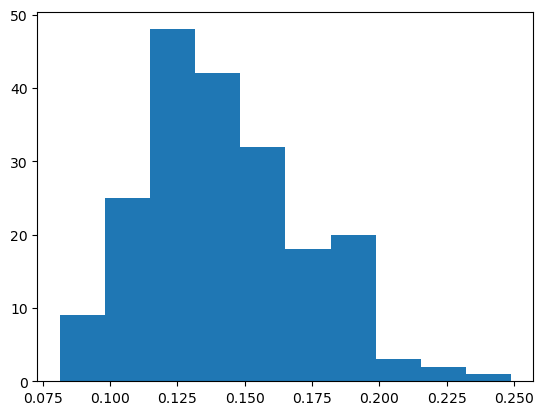

In [25]:
plt.hist(results)
plt.show()

Lower probability of failure: 3.8776 %

Upper probability of failure: 18.0617 %

In [26]:
results=np.array(results)
pop_size = len(results)
pop_5pc = int(pop_size*0.05)
sorted_result_args = np.argsort(results)
best_5p_res = results[sorted_result_args[:pop_5pc]]
worst_5p_res = results[sorted_result_args[-pop_5pc:]]

best_5p_lambda = lambda_sample_conditioned[sorted_result_args[:pop_5pc]]
worst_5p_lambda = lambda_sample_conditioned[sorted_result_args[-pop_5pc:]]

print(best_5p_res)
print(worst_5p_res)

[0.08141962 0.08577406 0.08805031 0.08805031 0.09014675 0.09014675
 0.09243697 0.09243697 0.09453782 0.09894737]
[0.19512195 0.19733925 0.19777778 0.19777778 0.20535714 0.20805369
 0.21524664 0.22072072 0.22573363 0.24885845]


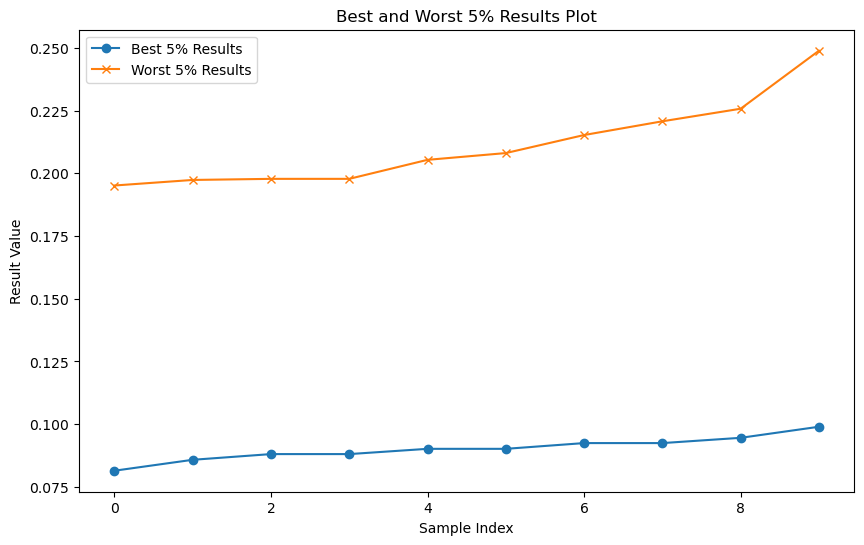

In [27]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the best 5% results
ax.plot(best_5p_res, label='Best 5% Results', marker='o', linestyle='-')

# Plot the worst 5% results
ax.plot(worst_5p_res, label='Worst 5% Results', marker='x', linestyle='-')

# Add labels and legend
ax.set_xlabel('Sample Index')
ax.set_ylabel('Result Value')
ax.set_title('Best and Worst 5% Results Plot')
ax.legend()

# Show the plot
plt.show()

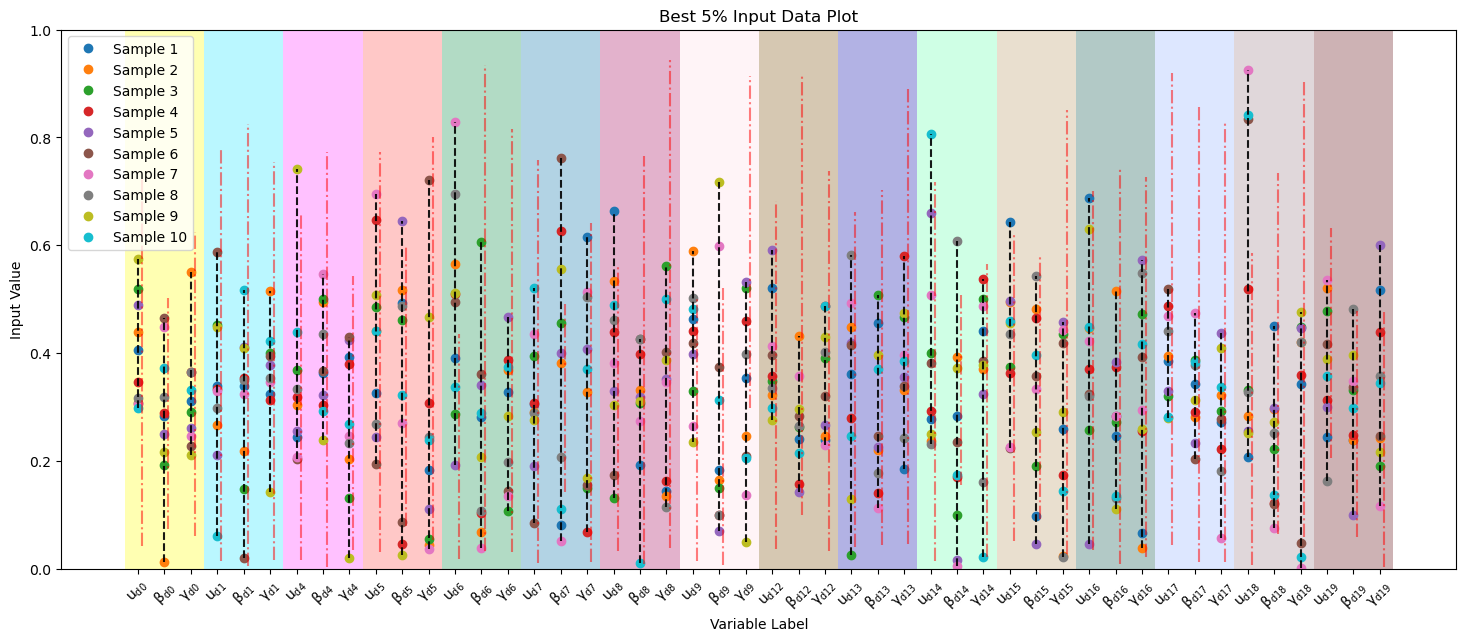

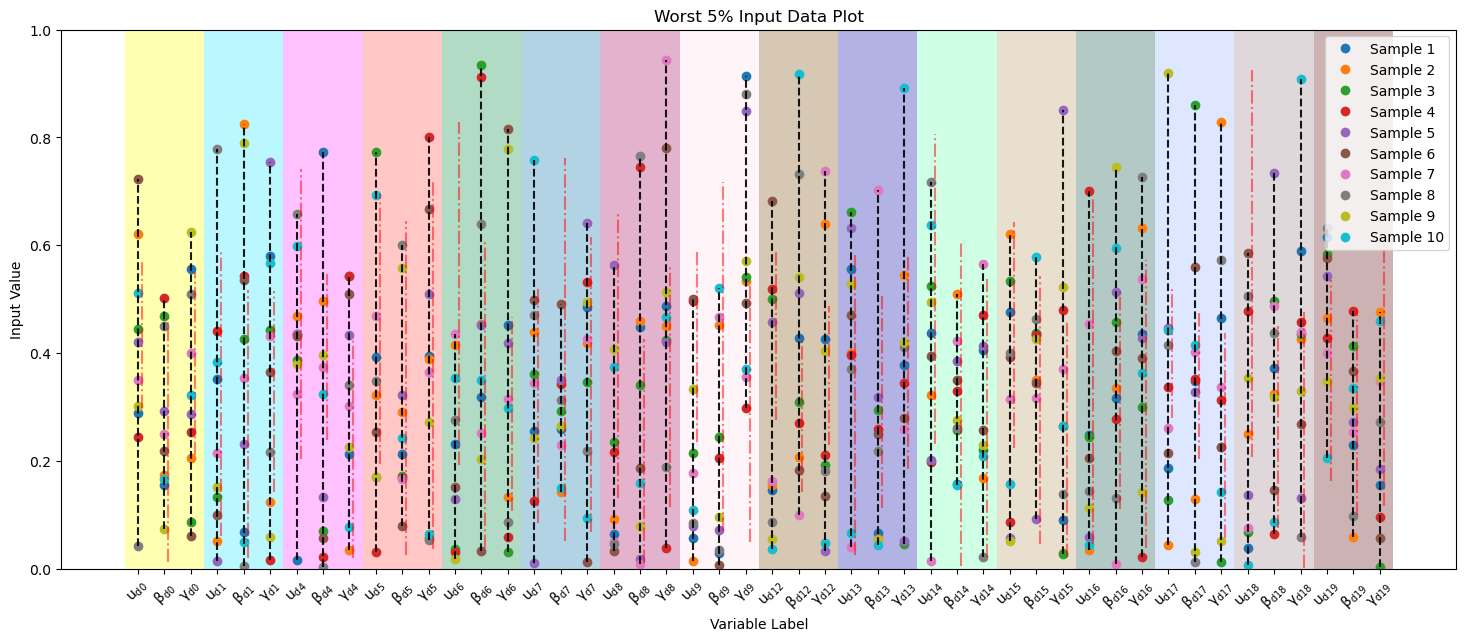

In [28]:
# %matplotlib qt
# Get the variable labels from the first sample (assuming all samples have the same variables)
variable_labels = [var for var in lambda_sample_conditioned.getDescription()]

variable_labels_tex = [f'${latex(sp.Symbol(var))}$' for var in lambda_sample_conditioned.getDescription()]


# Create separate figures and axes for the best and worst 5% plots
fig_best, ax_best = plt.subplots(figsize=(18, 7))
fig_worst, ax_worst = plt.subplots(figsize=(18, 7))

params = {'mathtext.default': 'regular' }  # Allows tex-style title & labels
plt.rcParams.update(params)

# Plot the best 5% input data
for i in range(len(best_5p_lambda)):
    ax_best.plot(best_5p_lambda[i], 'o',  label=f'Sample {i + 1}')

# Plot the worst 5% input data
for i in range(len(worst_5p_lambda)):
    ax_worst.plot(worst_5p_lambda[i], 'o', label=f'Sample {i + 1}')

# Rotate x-axis labels for better readability
ax_best.tick_params(axis='x', rotation=45)
ax_worst.tick_params(axis='x', rotation=45)

# Add labels and legend for the best 5% plot
ax_best.set_xlabel('Variable Label')
ax_best.set_ylabel('Input Value')
ax_best.set_title('Best 5% Input Data Plot')
ax_best.legend()

# Add labels and legend for the worst 5% plot
ax_worst.set_xlabel('Variable Label')
ax_worst.set_ylabel('Input Value')
ax_worst.set_title('Worst 5% Input Data Plot')
ax_worst.legend()

ax_worst.set_ylim(0,1)# Show the plots
ax_best.set_ylim(0,1)# Show the plots

# Define a color mapping dictionary for variables with the same index
color_mapping = {}
color_idx = 0
for var_label in variable_labels:
    index = re.match('.*?([0-9]+)$', str(var_label)).group(1)  # Extract the index part (e.g., '0')
    if index not in color_mapping:
        color_idx += 1
        color_mapping[index] = iota.hex_to_rgba(iota.color_palette_3[color_idx],as_float=True)


for i, var_label in enumerate(variable_labels):
    # Process best 5%
    var_data_best = [sample[variable_labels.index(var_label)] for sample in best_5p_lambda]
    var_index = int(re.match('.*?([0-9]+)$', str(var_label)).group(1))
    min_val_best = min(var_data_best)
    max_val_best = max(var_data_best)

    # Plot vertical lines for best 5%
    ax_best.axvline(x=i, ymin=min_val_best, ymax=max_val_best, color='black', linestyle='--', alpha=0.9)
    ax_best.axvspan(i - 0.5, i + 0.5, facecolor=color_mapping[str(var_index)], alpha=0.3)

    # Process worst 5%
    var_data_worst = [sample[variable_labels.index(var_label)] for sample in worst_5p_lambda]
    min_val_worst = min(var_data_worst)
    max_val_worst = max(var_data_worst)

    # Plot vertical lines for worst 5%
    ax_worst.axvline(x=i, ymin=min_val_worst, ymax=max_val_worst, color='black', linestyle='--', alpha=0.9)
    ax_worst.axvspan(i - 0.5, i + 0.5, facecolor=color_mapping[str(var_index)], alpha=0.3)

    # Plot vertical lines representing the span of the other axis (worst on best, best on worst)
    ax_best.axvline(x=i + 0.15, ymin=min_val_worst, ymax=max_val_worst, color='red', linestyle='dashdot', alpha=0.5, linewidth=1.5)
    ax_worst.axvline(x=i + 0.15, ymin=min_val_best, ymax=max_val_best, color='red', linestyle='dashdot', alpha=0.5, linewidth=1.5)


# Set the x-axis ticks and labels
ax_best.set_xticks(list(range(len(variable_labels))))
ax_best.set_xticklabels(variable_labels_tex)
ax_worst.set_xticks(list(range(len(variable_labels))))
ax_worst.set_xticklabels(variable_labels_tex)


#plt.tight_layout()
plt.show()